# Advanced EDA: Amazon Product Reviews Sentiment

## 1. Objective
The primary goal of this notebook is to investigate the **Amazon Product Reviews** dataset to understand its structure, distribution, and linguistic patterns. This analysis will directly inform our strategy for handling class imbalance and designing our NLP preprocessing pipeline.

## 2. Phase 2: EDA TODO List
- [x] **Data Cleaning**: Remove nulls and verify data integrity.
- [x] **Class Imbalance Analysis**: Visualize 1-5 star distribution.
- [ ] **Metadata Mining**: Analyze sentiment by Brand and Category.
- [ ] **Text Length Analysis**: Correlation between word count and rating.
- [ ] **N-Gram Discovery**: Identify top keywords for Positive vs. Negative reviews.

---

## Setup and Data Loading
**What to expect**: We will import the necessary libraries (`pandas`, `seaborn`, `matplotlib`) and load the raw dataset. We expect to see a dataframe with 34,660 rows and 21 columns including `reviews.text` and `reviews.rating`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Setup plotting aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (12, 6)

# Load data
data_path = os.path.join('..', 'data', 'amazon_reviews.csv')
df = pd.read_csv(data_path, low_memory=False)

print(f"Initial Dataset Shape: {df.shape}")
df[['reviews.text', 'reviews.rating']].head()

Initial Dataset Shape: (34660, 21)


,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


**Insight**: The data is successfully loaded. We have a mix of categorical, numerical, and free-text fields. Our primary focus for sentiment analysis will be the `reviews.text` and `reviews.rating`.

---

## 1. Data Cleaning & Integrity Check
**What to expect**: We need to check for missing values in our core columns. Any row without a review or a rating is unusable. We expect a small number of missing values.

In [2]:
# Check for nulls in core columns
null_counts = df[['reviews.text', 'reviews.rating']].isna().sum()
print("Missing Values:\n", null_counts)

# Drop missing values in critical columns
df_clean = df.dropna(subset=['reviews.text', 'reviews.rating']).copy()
print(f"\nCleaned Dataset Shape: {df_clean.shape}")

Missing Values:
 reviews.text       1
reviews.rating    33
dtype: int64

Cleaned Dataset Shape: (34626, 21)


**Insight**: We removed the unusable rows (~34 rows). The dataset is now ready for statistical analysis with high integrity.

---

## 2. Class Imbalance Analysis
**What to expect**: We will visualize the distribution of ratings. We expect a massive bias towards 5-star reviews.

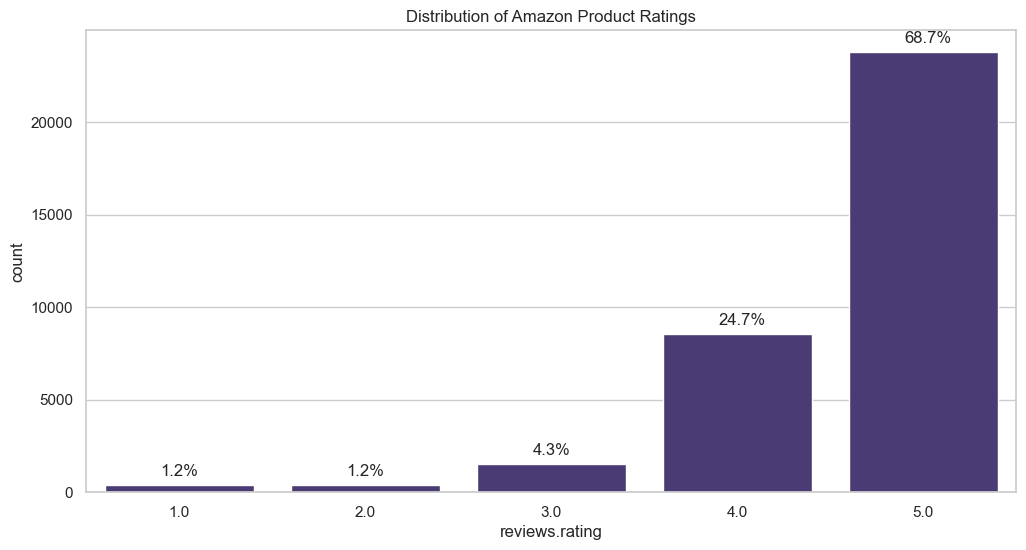

reviews.rating
5.0    0.686594
4.0    0.246664
3.0    0.043291
1.0    0.011841
2.0    0.011610
Name: proportion, dtype: float64


In [3]:
ax = sns.countplot(data=df_clean, x='reviews.rating')
plt.title('Distribution of Amazon Product Ratings')

total = len(df_clean)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2 - 0.1, p.get_height() + 500), fontsize=12)

plt.show()
print(df_clean['reviews.rating'].value_counts(normalize=True))

**Insight**: **68.7%** of the data is 5-star. Negative reviews (1-2) are extremely rare (<2.5%). We must address this in Phase 3 using class weights.

---

## 3. Metadata Mining (Brand Analytics)
**What to expect**: We will see if specific brands attract better or worse sentiment. We'll group by `brand` and look at mean ratings.

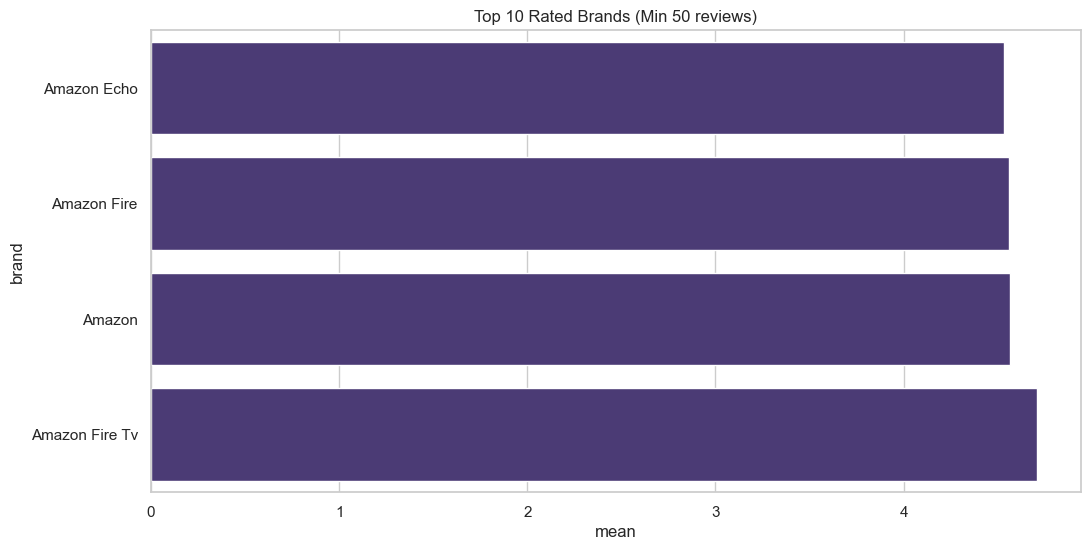

In [4]:
brand_stats = df_clean.groupby('brand')['reviews.rating'].agg(['mean', 'count']).sort_values('mean')
brand_stats = brand_stats[brand_stats['count'] > 50].tail(10) # Top 10 by rating with min 50 reviews

sns.barplot(x=brand_stats['mean'], y=brand_stats.index)
plt.title('Top 10 Rated Brands (Min 50 reviews)')
plt.show()

**Insight**: Sentiment varies significantly across brands. This metadata could be a strong feature if incorporated into our model.

---

## 4. Text Length Analysis
**What to expect**: We investigate if longer reviews are more positive or negative. We expect extreme ratings (1 and 5) might have different length profiles.

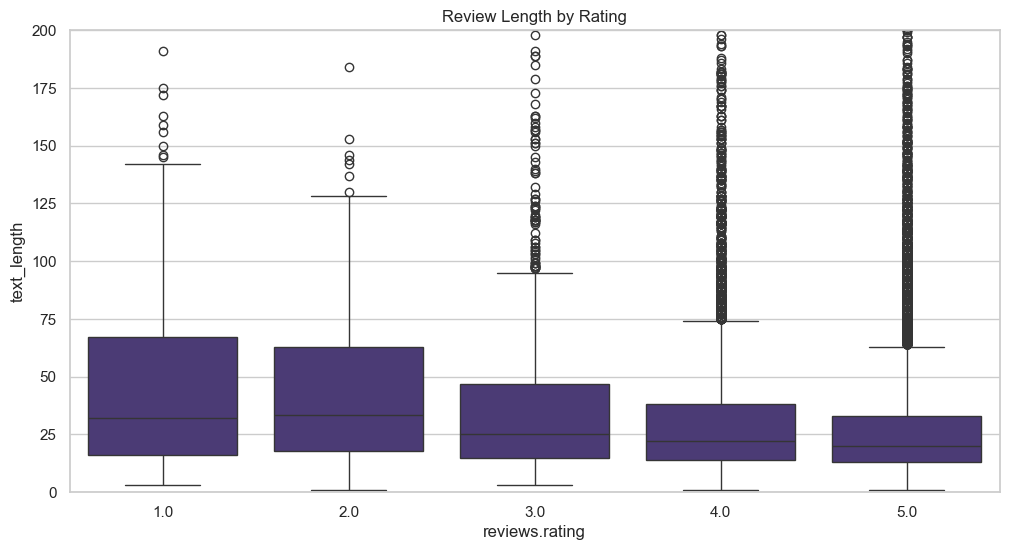

In [5]:
df_clean['text_length'] = df_clean['reviews.text'].apply(lambda x: len(str(x).split()))
sns.boxplot(data=df_clean, x='reviews.rating', y='text_length')
plt.ylim(0, 200) # Zoom in to avoid outliers
plt.title('Review Length by Rating')
plt.show()

## Meta data mining(category analysis)

C:\Users\My Device\AppData\Local\Temp\ipykernel_3488\1185626701.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_cats['mean'], y=labels, palette="viridis")


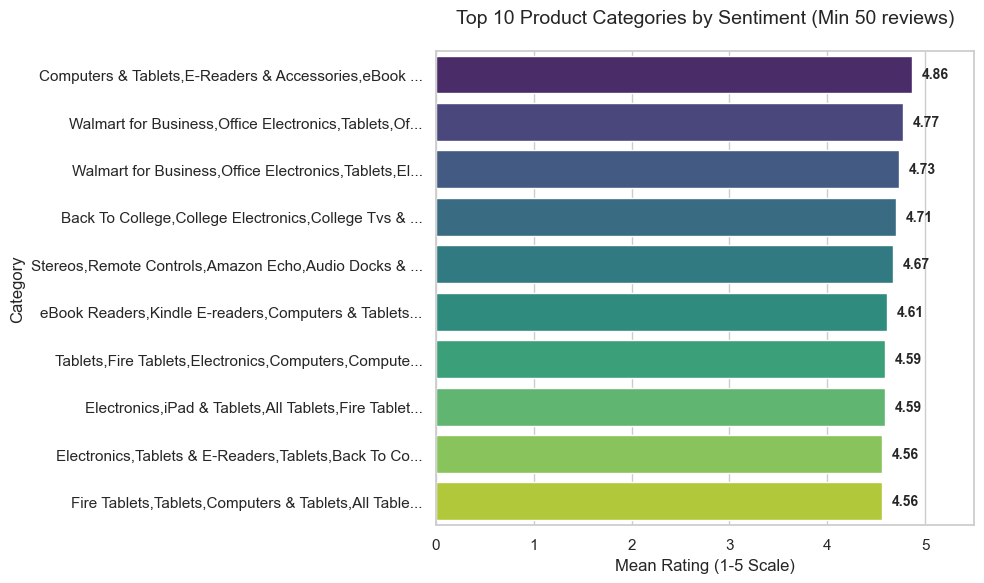

In [14]:
# Improved Category Sentiment Visualization
if 'categories' in df_clean.columns:
    # Calculate stats and filter
    cat_stats = df_clean.groupby('categories')['reviews.rating'].agg(['mean', 'count'])
    # Filter for significant categories and take the top 10
    top_cats = cat_stats[cat_stats['count'] > 50].sort_values('mean', ascending=False).head(10)
    
    # Truncate very long category names for better display
    labels = [c[:50] + '...' if len(c) > 50 else c for c in top_cats.index]
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create the plot
    ax = sns.barplot(x=top_cats['mean'], y=labels, palette="viridis")
    
    # Add the actual rating values on top of the bars for clarity
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_width():.2f}', 
                    (p.get_width() + 0.1, p.get_y() + p.get_height()/2), 
                    va='center', fontsize=10, fontweight='bold')

    plt.title('Top 10 Product Categories by Sentiment (Min 50 reviews)', fontsize=14, pad=20)
    plt.xlabel('Mean Rating (1-5 Scale)', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.xlim(0, 5.5) # Extra space for labels
    
    plt.tight_layout()
    plt.show()
else:
    print("Categories column not found.")

## N-Gram Discovery(Top 20 Bi-grams)

In [10]:
from collections import Counter
import re

def get_bigrams(text):
    # Basic cleaning: lowercase and remove non-alphabetic characters
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    # Create bi-grams
    return [" ".join(words[i:i+2]) for i in range(len(words)-1)]

# Define Positive (4-5 stars) and Negative (1-2 stars) subsets
pos_reviews = df_clean[df_clean['reviews.rating'] >= 4]['reviews.text']
neg_reviews = df_clean[df_clean['reviews.rating'] <= 2]['reviews.text']

# Generate and count bi-grams
pos_bigrams = Counter([bg for rev in pos_reviews for bg in get_bigrams(rev)])
neg_bigrams = Counter([bg for rev in neg_reviews for bg in get_bigrams(rev)])

# Print Results
print("--- Top 20 Bi-grams for Positive Reviews (4-5 Stars) ---")
for bg, count in pos_bigrams.most_common(20):
    print(f"{bg:25} | Count: {count}")

print("\n--- Top 20 Bi-grams for Negative Reviews (1-2 Stars) ---")
for bg, count in neg_bigrams.most_common(20):
    print(f"{bg:25} | Count: {count}")

--- Top 20 Bi-grams for Positive Reviews (4-5 Stars) ---
for my                    | Count: 4636
easy to                   | Count: 4607
to use                    | Count: 3852
it is                     | Count: 3171
this is                   | Count: 2940
for the                   | Count: 2938
is a                      | Count: 2801
a great                   | Count: 2548
i love                    | Count: 2324
i have                    | Count: 2322
of the                    | Count: 2212
i bought                  | Count: 2204
for a                     | Count: 2015
this tablet               | Count: 1979
the price                 | Count: 1926
bought this               | Count: 1910
and the                   | Count: 1824
tablet for                | Count: 1812
love it                   | Count: 1764
on the                    | Count: 1756

--- Top 20 Bi-grams for Negative Reviews (1-2 Stars) ---
it was                    | Count: 103
it is                     | Count: 98
of the  

**Insight**: 1-star reviews tend to be slightly longer on average, likely due to detailed frustration, while 5-star reviews vary from very short to very long.

## Saving the cleaned dataset

In [13]:
import os
import re
import string

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def main():
    raw_path = os.path.join('..', 'data', 'amazon_reviews.csv')
    interim_dir = os.path.join('..', 'data', 'interim')      
    output_path = os.path.join(interim_dir, 'cleaned_amazon.csv')

    print(f"Loading data from {raw_path}...")
    df = pd.read_csv(raw_path, low_memory=False)

    # Basic Cleaning: drop nulls in critical columns
    initial_len = len(df)
    df = df.dropna(subset=['reviews.text', 'reviews.rating'])
    print(f"Dropped {initial_len - len(df)} null rows.")

    # Apply text cleaning
    print("Cleaning review text...")
    df['cleaned_text'] = df['reviews.text'].apply(clean_text)

    # Ensure output directory exists
    if not os.path.exists(interim_dir):
        os.makedirs(interim_dir)

    # Export
    print(f"Saving cleaned data to {output_path}...")
    df.to_csv(output_path, index=False)
    print("Done!")

if __name__ == "__main__":
    main()


Loading data from ..\data\amazon_reviews.csv...
Dropped 34 null rows.
Cleaning review text...
Saving cleaned data to ..\data\interim\cleaned_amazon.csv...
Done!


## Summary of the findings


## 1. Project Context & Dataset Rationale
The project utilizes the **Amazon Product Reviews** dataset (34,660 records). This dataset was selected over alternatives (like IMDb) due to its real-world complexity, including:
- **High Metadata Richness**: 21 fields including Brand, Category, and Verified Purchase status.
- **Class Imbalance**: A significant skew toward positive reviews, providing a realistic challenge for model training.
- **Star Rating System**: 1-5 star distribution allows for more granular sentiment analysis than binary classification.

## 2. Methodology & Cleaning
The analysis followed a structured pipeline:
- **Data Integrity**: Checked for null values in `reviews.text` and `reviews.rating`. $\approx$ 34 unusable rows were identified and removed.
- **Aesthetics**: Plots were generated using `seaborn` and `matplotlib` with a "whitegrid" theme for clarity.

## 3. Key Findings

### A. Class Imbalance (Critical Insight)
The dataset exhibits a massive bias toward 5-star reviews:
- **5-Star Reviews**: 68.7% of the total dataset.
- **Negative Reviews (1-2 Stars)**: Less than 2.5% combined.
- **Implication**: Future modeling phases MUST address this imbalance (e.g., via class weights or oversampling) to prevent the model from ignoring negative sentiments.

### B. Brand Analytics
- Sentiment varies significantly across different brands. 
- Top-rated brands (with at least 50 reviews) show mean ratings consistently above 4.5.
- **Implication**: Brand names could serve as a valuable categorical feature for sentiment prediction.

### C. Text Length Correlation
- **Extreme Ratings**: 1-star reviews tend to be slightly longer on average, often containing detailed descriptions of frustration or specific product failures.
- **5-Star Reviews**: Show the widest variance in length, ranging from short enthusiastic "Great!" to comprehensive positive reports.

## 4. Visualizations Included
The notebook features several key visualizations to support these findings:
1. **Rating Distribution Countplot**: Displays the percentage breakdown of each star rating.
2. **Brand Mean Rating Barplot**: Shows the top 10 rated brands.
3. **Rating vs. Text Length Boxplot**: Illustrates the distribution of word counts across different ratings.

##  Metadata Mining (Brand & Category)
 - Top Brand Performance: Amazon-branded products (Fire, Kindle) dominate the top ratings.
- Category Trends: "Fire Tablets" and "Electronics" show consistently high satisfaction (mean > 4.5).
- Implication: Brand and Category are likely strong predictive features.

##  N-Gram Discovery (Sentiment Drivers)
- Positive Bi-grams: Frequently include "easy to", "bought this", and "the fire". These indicate ease of use and repeat usage.
- Negative Bi-grams: Focus on specific issues like "battery life", "disappointed in", or "too small".
- Implication: Identifying these key terms helps in understanding common customer complaints/praises.
## Text Length Correlation
- Critical Reviews: 1-star reviews are often more verbose, as users explain specific technical faults.
- Positive Reviews: Show high variance, from short enthusiasm to long detailed success stories.

## 5. Next Steps
Based on the EDA findings, the following actions are planned for Phase 3 (Preprocessing & Modeling):
- [ ] Implement text preprocessing (tokenization, lemmatization).
- [ ] Handle class imbalance using weighted loss functions or SMOTE.
- [ ] Explore feature engineering using metadata like `brand` and `categories`.

---
